# Pandemia en Twitter

_Nicole Lastra Quiroz - Agosto 2022_


## Objetivo

Generar análisis de sentimientos de los twitters recopilados en período de pandemia por Covid19.

## Desarrollo del proyecto

Se inicia el proyecto con la carga de librerías, sin olvidar el ignorar los warnings para efectos de limpieza del código.

In [28]:
# Carga de librerías
# ---------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import sklearn.neighbors
import sklearn.metrics as metrics
import requests
import json
import re
import nltk
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB 

import warnings
warnings.filterwarnings('ignore')

Se procede con la carga de datos, los cuales han sido entregados en dos archivos `.csv`. Normalmente utilizaríamos el respectivo dataset de prueba para las pruebas finales de los modelos, y el de entrenamiento, para el entrenamiento previo de los mencionados modelos, pero en esta ocasión, velando por una distribución correcta de las etiquetas de los respectivos datasets, y en busqueda de los mejores resultados, primero trabajaremos con un dataset que contiene la concatenación de todos los datos.

De esta forma, los datos serán cargados como `train_data`, `test_data` y `df` (este ultimo contiene a los datos de los anteriores).

In [29]:
# Carga de datos:
# ------------------------------------------------------------------------------
train_data = pd.read_csv('cv_train.csv', 
                         on_bad_lines = 'skip', 
                         sep          = ';'
                        )
test_data  = pd.read_csv('cv_test.csv', 
                         on_bad_lines = 'skip', 
                         sep          = ';'
                        )
df         = pd.concat([train_data,test_data])

# Para ver 4 filas de ejemplo del contenido de df
# ------------------------------------------------------------------------------
df.sample(4) 


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30624,34423,79375,"Jackson, MS",06-04-2020,A line forming again at the grocery store this...,Positive
25016,28815,73767,South Africa,29-03-2020,Here s a gut punch of a quote There s a queue ...,Negative
2823,6622,51574,Earth Citizen,18-03-2020,My main question with is how much food is goin...,Extremely Negative
34929,38728,83680,"Washington, DC",08-04-2020,Consumer companies that were set to sponsor th...,Positive


### Exploración de datos

Se realizan revisiones básicas, identificando nombre de  columnas, y contando el total de filas y columnas.

In [30]:
# Columnas en df:
# ------------------------------------------------------------------------------
print('Nombre columnas:',df.columns)

# Número de columnas y filas en df:
# ------------------------------------------------------------------------------
print('Cantidad de Filas y columnas:',df.shape)

Nombre columnas: Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
Cantidad de Filas y columnas: (44955, 6)


Teniendo claro esto, se procede con una revisión general de los valores no nulos, el conteo total por variables y el tipo de estas.

In [31]:
# Información de las variables en set general:
# ------------------------------------------------------------------------------
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


Se observa que existen datos `NaN` en la columna `Location`, pero para los efectos de este estudio no es algo relevante a considerar, ya que vamos a prescindir de esta columna, así como de otras.

Por otro lado, existen dos columnas, de un total de 6, del tipo `int64`, mientras que el resto son del tipo `object`.

In [32]:
# Información de las variables en el train set:
# ------------------------------------------------------------------------------
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [33]:
# Información de las variables en el test set:
# ------------------------------------------------------------------------------
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


Al revisar los data sets se prueba y entrenamiento (por separados), se encuentran hallazgos de la misma índole de `df`:

* El set de entrenamiento cuenta con 41157 filas de datos, distribuidos en 7 columnas con variables del tipo numérica en dos casos y objeto en los otros cuatro casos.

* Lo mismo se repite para el set de prueba, con la diferencia que este cuenta con 3798 filas de datos.

* En el caso de ambos, se observa que hay valores nulos en la columna `Location` (datos relativos a la ubicación desde donde se emitió la información).

### Visualizaciones

Para efectos del estudio, es importante revisar la gráfica de las etiquetas o categorías, en este caso entregadas por la columna `Sentiment`.

Número total de tweets "Neutros": 8332
Número total de tweet "Positivos": 12369
Número total de tweet "Extremadamente Negativos": 6073
Número total de tweet "Negativos": 10958
Número total de tweet "Extremadamente Positivos": 7223


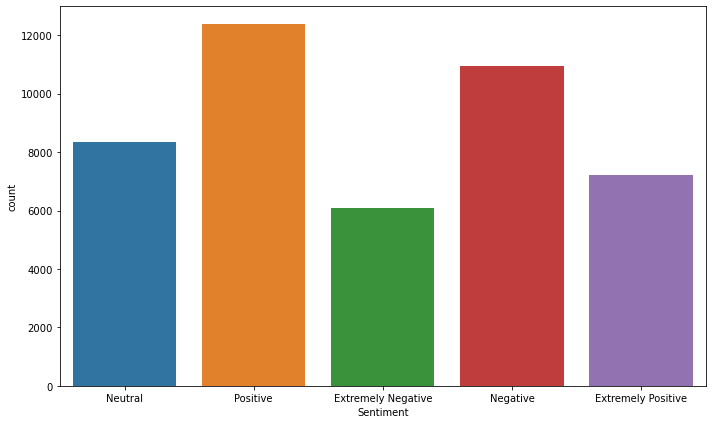

In [34]:
# Grafico de barras de etiquetas/sentimientos
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(10, 6))
sns.countplot(df.Sentiment)
plt.tight_layout()


# Variables auxiliares para conteo de tweets por sentimiento
# ------------------------------------------------------------------------------
s0 = len(df[df['Sentiment']=='Neutral'])
s1 = len(df[df['Sentiment']=='Positive'])
s2 = len(df[df['Sentiment']=='Extremely Negative'])
s3 = len(df[df['Sentiment']=='Negative'])
s4 = len(df[df['Sentiment']=='Extremely Positive'])


# Mostrar el numero total por cada sentimiento
# ------------------------------------------------------------------------------
print('Número total de tweets "Neutros":' , s0)
print('Número total de tweet "Positivos":', s1)
print('Número total de tweet "Extremadamente Negativos":', s2)
print('Número total de tweet "Negativos":', s3)
print('Número total de tweet "Extremadamente Positivos":', s4)

#### Hallazgos generales

* El sentimiento predominante en los tweets es **Positivo**, seguido de cerca por el **Negativo**.
* El sentimiento menos presente es el  **Extremamente negativo**.


### Limpieza de datos 

Ahora, se eliminarán columnas innecesarias para el estudio, dejando únicamente los tweets y las labels (`Sentiment`) correspondientes. 

* Por tema de orden, esto se aplicará a todos los set de datos.

In [35]:
# Eliminación de duplicados y reset + Visualización de 5 tweets
# ---------------------------------------------------------------------
df = df.drop(columns =['UserName', 'ScreenName','Location','TweetAt'])
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [36]:
# Eliminación de duplicados y reset + Visualización de 5 tweets
# ---------------------------------------------------------------------
train_data = train_data.drop(columns =['UserName', 'ScreenName','Location','TweetAt'])
train_data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [37]:
# Eliminación de duplicados y reset + Visualización de 5 tweets
# ---------------------------------------------------------------------
test_data = test_data.drop(columns =['UserName', 'ScreenName','Location','TweetAt'])
test_data.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


En todos los data sets se observa que existen hashtags, páginas web, así como otros caracteres que deberán ser limpiados en la etapa de preprocesado (al menos para `df`).

Se eliminarán también los tweets duplicados, con la finalidad de que no interfieran en los resultados del modelo.

In [38]:
# Eliminación de duplicados y reset
# ---------------------------------------------------------------------
df       = df.drop_duplicates(keep = "first")
df_reidx = df.reset_index(drop = True)
df_reidx.shape

(44952, 2)

Al observar los números, se concluye que habían 3 tweets duplicados en `df`.

In [39]:
# Eliminación de duplicados y reset
# ---------------------------------------------------------------------
train_data = train_data.drop_duplicates(keep = "first")
train_data_reidx = train_data.reset_index(drop = True)
train_data_reidx.shape

(41154, 2)

Al realizar la ultima tarea, se observa que se eliminaron 3 tweets, por lo que los 3 tweets de `df` venían del `train_data`.

Finalmente se procede con un conteo de los sentimientos predominantes en los tweets, en acuerdo a las etiquetas de set de datos.

In [40]:
# Conteo de etiquetas según categoría en training set
# ---------------------------------------------------------------------
df_reidx.Sentiment.value_counts()

Positive              12369
Negative              10956
Neutral                8331
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

Estos resultados vienen a complementar lo ya observado de forma gráfica en la sección de visualizaciones.

### Limpieza y Tokenización

Se revisarán las palabras con mayor frecuencia y con menor frecuencia en `df`, para luego ser eliminadas, con la finalidad de que no interfieran en el modelo.

In [41]:
# Identificación de palabras mas frcuentes
# ---------------------------------------------------------------------
freq = pd.Series(' '.join(df_reidx['OriginalTweet']).split()).value_counts()[:7]
freq

the    44187
to     40960
and    25414
of     23270
a      19664
in     19353
for    14584
dtype: int64

In [42]:
# Eliminación de palabras mas frecuentes
# ---------------------------------------------------------------------
freq = list(freq.index)
df_reidx['OriginalTweet'] = df_reidx['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df_reidx['OriginalTweet'].head()

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk your neighbours family exchange ph...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock is not only one which is empty.....
4    Me, ready go at supermarket during #COVID19 ou...
Name: OriginalTweet, dtype: object

In [43]:
# Identificación de palabras menos frecuentes
# ---------------------------------------------------------------------

freq = pd.Series(' '.join(df_reidx['OriginalTweet']).split()).value_counts()[-10:]
freq

(Covid-19,                 1
Ventures                   1
kick-in                    1
readiness,                 1
https://t.co/6CcnXAiNvY    1
https://t.co/iLQJzyfwoT    1
taping                     1
https://t.co/sA9yE3RZvK    1
this?a                     1
https://t.co/xyvbNsFeXA    1
dtype: int64

In [44]:
# Eliminación de palabras menos frecuentes
# ---------------------------------------------------------------------
freq = list(freq.index)
df_reidx['OriginalTweet'] = df_reidx['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df_reidx['OriginalTweet'].head()

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk your neighbours family exchange ph...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock is not only one which is empty.....
4    Me, ready go at supermarket during #COVID19 ou...
Name: OriginalTweet, dtype: object

Como apoyo extra, se corrigen las palabras mal escritas con ayuda de `TextBlob`.

In [45]:
# Corrección de palabras con TextBlob
# ---------------------------------------------------------------------
df_reidx['OriginalTweet'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    @MeNyrbie @Phil_Gahan @Chrisitv http://t.co/iF...
1    advice Talk your neighbours family exchange ph...
2    Coronavirus Australia: Woolworths give elderly...
3    By food stock is not only one which is empty.....
4    He, ready go at supermarket during #COVID19 ou...
Name: OriginalTweet, dtype: object

Se define un objeto para llamar a `WordNetLemmatizer()`.

In [46]:
# Creación de objeto para lemmatization
# ---------------------------------------------------------------------
lm = WordNetLemmatizer()

Se crea un objeto contenedor de las stopwords, y se añaden palabras ya evidenciadas en la revisión anterior de los datos. En este caso también se elimina la palabra "**not**", debido a que muchos tweets podrían perder su calidad de "negatividad" o extrema "negatividad" al eliminar este, por ejemplo si dice "not good", sólo quedaría "good", esto es lo que se busca evitar. Lo mismo aplica a otras negaciones. 

In [47]:
# Obtención de listado de stopwords del ingles
# ---------------------------------------------------------------------
stop_words = list(stopwords.words('english'))

# Se añade la stoprword: amp, ax, ex y se elimina not
# ---------------------------------------------------------------------
stop_words.extend (list(stopwords.words('french')))
stop_words.extend(('amp','u','xa', 'xe', '100k', 'many','make'))
stop_words.remove('not')
stop_words.remove("aren't")
stop_words.remove("couldn't")
stop_words.remove("didn't")
stop_words.remove("don't")
stop_words.remove("doesn't")

print(stop_words)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

Se procede con el preprocesado de la información, en donde se definirá el corpus y las restricciones de este, como la eliminación de las páginas web, el convertido a minúsculas de todas las palabras, la separación de las palabras como items, la eliminación de las stopwords, entre otros.

Se aplica la función creada en el preprocessing de los tweets y se guardan en el corpus.

In [48]:
# Preprocesado de la información
# ---------------------------------------------------------------------

def text_transformation(df_col):
    corpus = []
    
    for item in df_col:
        
        # Eliminación de páginas web (palabras que empiezan por "http")
        # -------------------------------------------------------------
        new_item = re.sub('http\S+', ' ', str(item))
        
        # Eliminación de signos de puntuación
        regex = '[\\!\\"\\#\\$\\%\\&\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\&\\´]'
        new_item = re.sub(regex , ' ', new_item)
        
        #usando expresión regular eliminar cualquier caracter que no pertenezca al alfabeto
        new_item = re.sub('[^a-zA-Z]',' ', new_item)
        

        # Corrección de palabra (por algún motivo no funciona)
        # -------------------------------------------------------------
        #new_item = re.sub(r'usay', 'say', new_item)
        
         
        # Corrección de palabra (por algún motivo no funciona)
        # -------------------------------------------------------------
        #new_item = re.sub(r'covidcovid', 'covid', new_item)
        
        # Corrección de palabra (por algún motivo no funciona)
        # -------------------------------------------------------------
        #new_item = re.sub(r"coronaviruscovid", "coronavirus", new_item)
        #new_item = new_item.replace("coronaviruscovid", "coronavirus")
        
        # Corrección de palabra (por algún motivo no funciona)
        # --------------------------------------------------------------
        #new_item = re.sub (r'uplace', 'place', new_item)
            
        
        # Corrección de palabra (por algún motivo no funciona)
        # -------------------------------------------------------------
        #new_item = re.sub(r'needu', 'need you', new_item)
        
        
        # Corrección de palabra (por algún motivo no funciona)
        # -------------------------------------------------------------
        new_item = re.sub(r"covid coronavirus", "coronavirus", new_item)
        
        #convertir a minuscula
        # -------------------------------------------------------------
        new_item = new_item.lower() 
        new_item = re.split('\W+', new_item) 
        
        # Se mantienen tokens con una longitud de 2 o mas letras
        # -------------------------------------------------------------
        new_item = [token for token in new_item if len(token) > 1]
        
        # Busqueda/eliminación de stopwords + lematizatizado de palabras
        # -------------------------------------------------------------
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stop_words)]
        corpus.append(' '.join(str(x) for x in new_item))
        
        
   # Devolución de un corpus de los datos procesados
   # ------------------------------------------------------------------
    return corpus

In [49]:
# Aplicar función de preprocessing al texto + guardado en corpus
# ---------------------------------------------------------------------
corpus = text_transformation(df_reidx['OriginalTweet'])

Finalmente, se procede con la creación de un `WordCloud` en base al corpus generado. Para efectos de precisión  el `max_word` se fijado como _"hasta 6000 palabras"_.

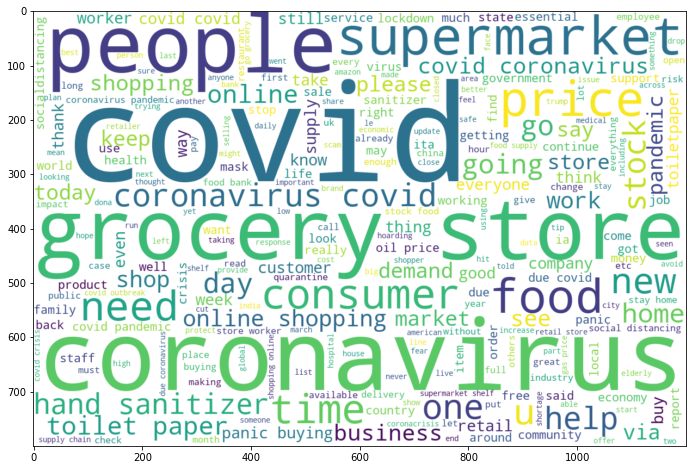

In [50]:
#Creación de wordcloud para ver las palabras más frecuentes
# ---------------------------------------------------------------------
plt.figure(figsize = (12, 8))

word_cloud = ""

for row in corpus:
    for word in row:
        word_cloud += " ".join(word)
        
wordcloud = WordCloud(width            = 1200, 
                      height           = 800,
                      background_color ='white',
                      max_words        = 6000,
                      regexp           = r"\w+",
                      collocation_threshold = 100,
                      min_font_size    = 11).generate(word_cloud)

plt.imshow(wordcloud, interpolation = 'bilinear')

Se observa que entre las prncipales palabras destacan "Covid", " Coronavirus", "Grosery store", "supermarket" y otras relativas a la pandemia y el estado de alerta mundial por las enfermedades, la comida y otros de la misma índole. Se dejaron las opciones compuestas por dos palabras, pero pese a que se intentó eliminar los resultados de los hashtags, esto no resultó (como la palabra _"covidcovid"_).

Se procede con la tokenización y conversión a vectores.



In [51]:
# tokenization y convertir oraciones limpias a vectores
# ---------------------------------------------------------------------
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

vectorizer = CountVectorizer(stop_words    = stop_words, 
                             strip_accents = 'ascii',
                             max_df        = 0.5, 
                             min_df        = 3,
                             ngram_range   = (1,1),
                             tokenizer     = token.tokenize
                            )

x = vectorizer.fit_transform(corpus)
y = df_reidx.Sentiment.values

print("X.shape : ",x.shape)
print("y.shape : ",y.shape)

X.shape :  (44952, 14421)
y.shape :  (44952,)


In [52]:
# Mezclar para que los datos positivos y negativos se 
# dividan por igual en set de entrenamiento y test
# ------------------------------------------------------------------------------
train_idx, test_idx = train_test_split(np.arange(df_reidx.shape[0]), 
                                       test_size    = 0.3,
                                       shuffle      = True, 
                                       random_state = 123
                                      )

x_train = x[train_idx]
y_train = y[train_idx]

x_test = x[test_idx]
y_test = y[test_idx]
print("Number of training examples:{}".format(len(train_idx)))
print("Number of testing examples:{}\n".format(len(test_idx)))
print("Training data: X_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(x_test.shape, y_test.shape))

Number of training examples:31466
Number of testing examples:13486

Training data: X_train : (31466, 14421), y_train : (31466,)
Testing data: X_test : (13486, 14421), y_test : (13486,)


### Entrenar modelos

Se trabajará en paralelo una comparativa entre un modelo por **Regresión Logística** y otro por **Multinomial Naive Bayes**.
En cada caso se definirá y entrenará el modelo, para luego imprimir su respectiva matriz de confusión y plot.

                    precision    recall  f1-score   support

Extremely Negative       0.66      0.59      0.62      1834
Extremely Positive       0.71      0.64      0.67      2136
          Negative       0.54      0.53      0.54      3303
           Neutral       0.63      0.72      0.67      2528
          Positive       0.57      0.59      0.58      3685

          accuracy                           0.61     13486
         macro avg       0.62      0.61      0.62     13486
      weighted avg       0.61      0.61      0.61     13486


 Accuracy for Logistic Regression model: 0.6064066439270355




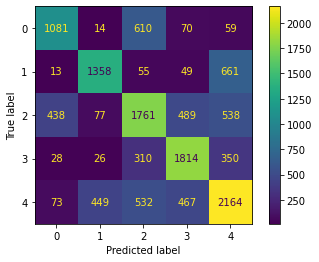

In [53]:
# Por regresión logística
# ---------------------------------------------------------------------
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)

# Predicción
# ---------------------------------------------------------------------
y_pred_test_lr = lr_clf.predict(x_test)
y_predprob_lr  = lr_clf.predict_proba(x_test)
matrix_lr      = confusion_matrix(y_test,y_pred_test_lr)

print(classification_report(y_test, y_pred_test_lr))
print("\n Accuracy for Logistic Regression model:",metrics.accuracy_score(y_test, y_pred_test_lr))
print("\n")

y_predict      = lr_clf.predict(x_test)
matrix_display = ConfusionMatrixDisplay(matrix_lr).plot()

Este primer modelo alcanza casi un 61% de accuracy, que no es malo, pero tampoco muy bueno.

### Cross Validation 

Con la esperanza de mejorar los modelos, se procede a una cross validatión.

In [54]:
# Para primer modelo
# ---------------------------------------------------------------------
acc_score_lr  = metrics.accuracy_score(y_pred_test_lr,y_test)
prec_score_lr = precision_score(y_test,y_pred_test_lr, 
                                average = 'macro')
recall_lr     = recall_score(y_test, y_pred_test_lr,
                                average = 'macro')
f1_lr         = f1_score(y_test,y_pred_test_lr,
                                average = 'macro')

matrix_lr     = confusion_matrix(y_test,y_pred_test_lr)

print('Logistic Regression Model\n')
print(str('Accuracy: '+'{:04.2f}'.format(acc_score_lr*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score_lr*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall_lr*100))+'%')
print('F1 Score: ',f1_lr)
print("\n")
print(matrix_lr)

Logistic Regression Model

Accuracy: 60.64%
Precision: 62.17%
Recall: 61.26%
F1 Score:  0.6157377081964732


[[1081   14  610   70   59]
 [  13 1358   55   49  661]
 [ 438   77 1761  489  538]
 [  28   26  310 1814  350]
 [  73  449  532  467 2164]]


Se observan mejoras respeco a precisión, pero no a Acurracy.

### Explicar predicción del modelo

Se observa que incluso despues de la validación cruzada, el modelo basado en Regresión logística fue mejor que el basado en Multimominal Naive Bayes.

Se revisarán a continuación las predicciones del modelo, versus los sentimientos reales (el etiquetado con el que venóian los datos), así como las principales palabras consideradas según dos categorías de ejemplo, enunciadas más adelante.

In [57]:
# Predicciones vs sentimientos originales
# ------------------------------------------------------------------------------
test_data = df_reidx.iloc[test_idx]
test_data['pred_label'] = y_pred_test_lr
test_data.head(4)[['OriginalTweet','Sentiment','pred_label']]

,OriginalTweet,Sentiment,pred_label
37303,"CBD can cure... nothing, officially. National ...",Neutral,Neutral
15145,Banks pressure #Healthcare firms now raise #dr...,Positive,Positive
28879,The #Coronavirus Outbreak is Making Dairy Farm...,Negative,Negative
24080,Carnivorous is an anagram #coronavirus - that ...,Negative,Negative


In [58]:
# 4 Ejemplos de cuando la etiqueta de predicción no se ajusta a la etiqueta real 
# ------------------------------------------------------------------------------
test_data[test_data['Sentiment'] != test_data['pred_label']].head(4)[['OriginalTweet','Sentiment','pred_label']].head(4)

,OriginalTweet,Sentiment,pred_label
20951,"""We are ramping up protect public,"" said an FB...",Negative,Extremely Negative
31141,Interesing disclosure re:food makers with inef...,Extremely Positive,Positive
44452,Twitter Feed: Covid-19 99.9% Other/Silly .01% ...,Negative,Extremely Negative
40357,@HeidiGiokos @flysaa So disturbing that SA is ...,Positive,Extremely Negative


In [59]:
#Features predichas por el modelo LR
# ------------------------------------------------------------------------------
feature_to_coef4 = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[4])}

In [60]:
# Top sentimientos positivos del modelo LR
# ------------------------------------------------------------------------------
print("Top de palabras positivas:")
sorted(feature_to_coef4.items(), 
       key     = lambda x: x[1], 
       reverse = True)[:10]

Top de palabras positivas:


[('positive', 1.687),
 ('surely', 1.654),
 ('confidence', 1.54),
 ('dedicated', 1.474),
 ('super', 1.455),
 ('thanks', 1.442),
 ('ecuador', 1.435),
 ('value', 1.428),
 ('interesting', 1.42),
 ('freely', 1.395)]

In [61]:
#Features predichas por el modelo LR
# ------------------------------------------------------------------------------
feature_to_coef0 = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}

In [62]:
# Top sentimientos extremadamente negativos del modelo LR
# ------------------------------------------------------------------------------
print("Top de palabras extremadamente negativas:")
sorted(feature_to_coef0.items(), 
       key     = lambda x: x[1], 
       reverse = True)[:10]

Top de palabras extremadamente negativas:


[('crisis', 4.456),
 ('hell', 3.956),
 ('kill', 3.749),
 ('killing', 3.648),
 ('scam', 3.531),
 ('worst', 3.414),
 ('dead', 3.371),
 ('war', 3.358),
 ('disaster', 3.204),
 ('died', 3.192)]

### Testeando el modelo con frases random

Se realiza testeado del modelo resultante con frases escritas, simulando nuevos tweets ya procesados.

In [71]:
# Just for fun
# ------------------------------------------------------------------------------
text=['I hate lockdown but also I hate places full of people so...', 'I wish I could turn back time, so that way I might be able to upload my assigment on time', 'I need to spend less time understanding every little thing in the code, I must stop my obssesions']
test_result = lr_clf.predict(vectorizer.transform(text))
print(test_result)

['Extremely Negative' 'Positive' 'Negative']


### Conclusiones finales


Como era de esperar, las palabras que más se destacaron en la nube, fueron las relativas a coronavirus como tal, así como sus derivados.
Respecto al trabajo geennrado, se concluye que fue una excelente decisión retirar negaciones y la palabra "not" de las "stopwords" aunque, pese a esto, no se consiguió evitar del todo las contradicciones o faltas de precisiones a la hora de determinar etiquetas según el modelo final.
En general, se esperaría pulir el modelo por medio del uso de otras herramientas, o  bien, de generar mejoras a las correcciones de vocabulario y preprocesado. 



